In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import numpy as np
import os
# import pandas as pd

2023-06-10 18:07:39.270905: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)
ds_path = "/drive0-storage/Gracia/dataset_1"

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-10 18:07:41.356240: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 18:07:42.133078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7910 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Found 21408 files belonging to 3 classes.
Using 17127 files for training.
Found 21408 files belonging to 3 classes.
Using 4281 files for validation.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 237.73611
(184, 216, 3)


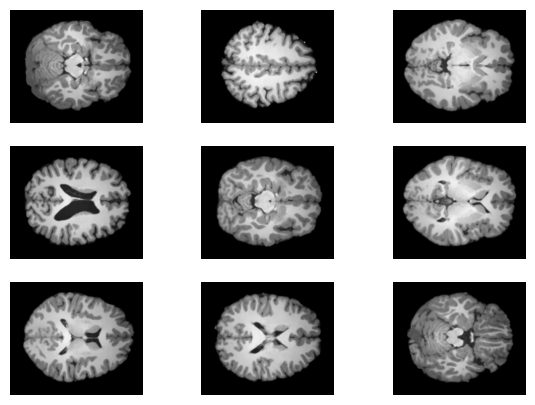

In [10]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [6]:
with tf.device("CPU"):
    AUTOTUNE = tf.data.AUTOTUNE
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    # Buffered prefetching
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [8]:
for images in train_ds.take(1):
    img = images[0]
    print(img.shape)  
    print(img.dtype)  
    print(np.min(img),np.max(img))  

(8, 184, 216, 3)
<dtype: 'float32'>
0.0 246.1778


In [6]:
len(validation_dataset)

67

## Model building

In [7]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [23]:
with tf.device("GPU"):
    vgg16 = build_vgg16()

    # add rescale layer, chain model
    rescale = tf.keras.layers.Rescaling(1./255)
    inputs = tf.keras.Input(shape = img_shape)
    x = rescale(inputs)
    outputs = vgg16(x)
    model = tf.keras.Model(inputs,outputs) 
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [19]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn1_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [25]:
EPOCH = 25

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[checkpoints_cb, callbacks])

Epoch 1/25
  6/536 [..............................] - ETA: 1:23 - loss: 1.0938 - accuracy: 0.5469WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0447s vs `on_train_batch_end` time: 0.1149s). Check your callbacks.


535/536 [============================>.] - ETA: 0s - loss: 1.0002 - accuracy: 0.5581

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 92s 170ms/step - loss: 1.0002 - accuracy: 0.5581 - val_loss: 1.0086 - val_accuracy: 0.5405
Epoch 2/25
535/536 [============================>.] - ETA: 0s - loss: 0.9950 - accuracy: 0.5583

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.9950 - accuracy: 0.5583 - val_loss: 1.0070 - val_accuracy: 0.5391
Epoch 3/25
535/536 [============================>.] - ETA: 0s - loss: 0.9911 - accuracy: 0.5582

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.9910 - accuracy: 0.5583 - val_loss: 0.9961 - val_accuracy: 0.5423
Epoch 4/25
535/536 [============================>.] - ETA: 0s - loss: 0.9725 - accuracy: 0.5622

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.9725 - accuracy: 0.5622 - val_loss: 0.9493 - val_accuracy: 0.5583
Epoch 5/25
535/536 [============================>.] - ETA: 0s - loss: 0.9163 - accuracy: 0.5908

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.9163 - accuracy: 0.5908 - val_loss: 0.8977 - val_accuracy: 0.6022
Epoch 6/25
535/536 [============================>.] - ETA: 0s - loss: 0.8767 - accuracy: 0.6103

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.8767 - accuracy: 0.6103 - val_loss: 0.8994 - val_accuracy: 0.5905
Epoch 7/25
535/536 [============================>.] - ETA: 0s - loss: 0.8426 - accuracy: 0.6255

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.8426 - accuracy: 0.6255 - val_loss: 0.8291 - val_accuracy: 0.6364
Epoch 8/25
536/536 [==============================] - ETA: 0s - loss: 0.8023 - accuracy: 0.6451

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.8023 - accuracy: 0.6451 - val_loss: 0.8453 - val_accuracy: 0.6191
Epoch 9/25
536/536 [==============================] - ETA: 0s - loss: 0.7625 - accuracy: 0.6685

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.7625 - accuracy: 0.6685 - val_loss: 0.7645 - val_accuracy: 0.6631
Epoch 10/25
536/536 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.6917

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.7109 - accuracy: 0.6917 - val_loss: 0.8155 - val_accuracy: 0.6439
Epoch 11/25
535/536 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.7197

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.6542 - accuracy: 0.7195 - val_loss: 0.7181 - val_accuracy: 0.6832
Epoch 12/25
535/536 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7575

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.5829 - accuracy: 0.7576 - val_loss: 0.6758 - val_accuracy: 0.7164
Epoch 13/25
535/536 [============================>.] - ETA: 0s - loss: 0.4913 - accuracy: 0.8001

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.4912 - accuracy: 0.8002 - val_loss: 0.5524 - val_accuracy: 0.7656
Epoch 14/25
535/536 [============================>.] - ETA: 0s - loss: 0.4052 - accuracy: 0.8415

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.4052 - accuracy: 0.8415 - val_loss: 0.4485 - val_accuracy: 0.8194
Epoch 15/25
535/536 [============================>.] - ETA: 0s - loss: 0.3056 - accuracy: 0.8828

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.3055 - accuracy: 0.8828 - val_loss: 0.4248 - val_accuracy: 0.8245
Epoch 16/25
535/536 [============================>.] - ETA: 0s - loss: 0.2294 - accuracy: 0.9155

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.2293 - accuracy: 0.9156 - val_loss: 0.3845 - val_accuracy: 0.8460
Epoch 17/25
535/536 [============================>.] - ETA: 0s - loss: 0.1628 - accuracy: 0.9409

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.1628 - accuracy: 0.9409 - val_loss: 0.4279 - val_accuracy: 0.8465
Epoch 18/25
535/536 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9604

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.1148 - accuracy: 0.9604 - val_loss: 0.3606 - val_accuracy: 0.8690
Epoch 19/25
535/536 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.9663

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.0978 - accuracy: 0.9663 - val_loss: 0.2624 - val_accuracy: 0.8989
Epoch 20/25
535/536 [============================>.] - ETA: 0s - loss: 0.0698 - accuracy: 0.9767

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.0698 - accuracy: 0.9767 - val_loss: 0.2518 - val_accuracy: 0.9050
Epoch 21/25
535/536 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9745

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 170ms/step - loss: 0.0729 - accuracy: 0.9745 - val_loss: 0.2000 - val_accuracy: 0.9303
Epoch 22/25
535/536 [============================>.] - ETA: 0s - loss: 0.0524 - accuracy: 0.9831

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


536/536 [==============================] - 91s 169ms/step - loss: 0.0524 - accuracy: 0.9831 - val_loss: 0.2009 - val_accuracy: 0.9279
Epoch 23/25
535/536 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9932

INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets


INFO:tensorflow:Assets written to: ./cnn1_checkpoints/assets



Reached 99% accuracy, cancelling training
536/536 [==============================] - 91s 170ms/step - loss: 0.0242 - accuracy: 0.9932 - val_loss: 0.2060 - val_accuracy: 0.9331


In [33]:
model.save('./models/cnn1_23epoch.h5')

### Training evaluation

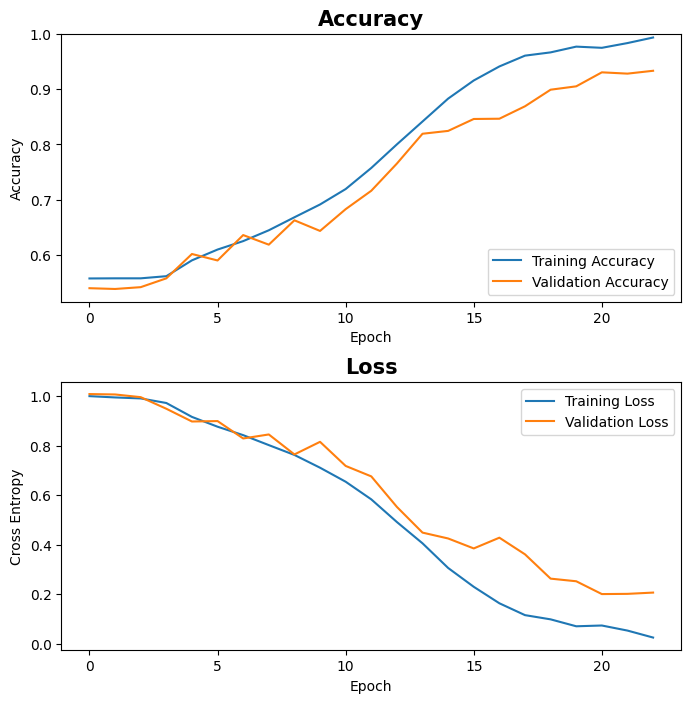

In [26]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')


plt.subplots_adjust(hspace=0.3)
plt.show()

In [51]:
acc

[0.558066189289093,
 0.5582997798919678,
 0.5582997798919678,
 0.5621533393859863,
 0.5907631516456604,
 0.6102644801139832,
 0.6255035996437073,
 0.6450633406639099,
 0.668535053730011,
 0.6916564702987671,
 0.7195072174072266,
 0.7575757503509521,
 0.800198495388031,
 0.8414783477783203,
 0.8828166127204895,
 0.915571928024292,
 0.9409120082855225,
 0.96041339635849,
 0.9663105010986328,
 0.9767034649848938,
 0.9745430946350098,
 0.9831260442733765,
 0.9931686520576477]

In [52]:
val_acc

[0.5404772758483887,
 0.5390734672546387,
 0.542349100112915,
 0.5582592487335205,
 0.6022461652755737,
 0.590547502040863,
 0.6364061832427979,
 0.6190921664237976,
 0.6630790829658508,
 0.643893301486969,
 0.6832007765769958,
 0.7164248824119568,
 0.765559196472168,
 0.8193729519844055,
 0.8245203495025635,
 0.8460458517074585,
 0.8465138077735901,
 0.8689752221107483,
 0.8989236950874329,
 0.905007004737854,
 0.930276095867157,
 0.9279363751411438,
 0.9330837726593018]

In [53]:
loss

[1.000239610671997,
 0.9950087070465088,
 0.9910094738006592,
 0.9725314974784851,
 0.9163156151771545,
 0.8766647577285767,
 0.8425648212432861,
 0.8022703528404236,
 0.7624817490577698,
 0.7108744382858276,
 0.6542230248451233,
 0.5829288959503174,
 0.49122199416160583,
 0.4051797091960907,
 0.3055321276187897,
 0.2293291836977005,
 0.16276979446411133,
 0.11481393873691559,
 0.0977608859539032,
 0.06975867599248886,
 0.07288570702075958,
 0.05237499997019768,
 0.024199914187192917]

In [54]:
val_loss

[1.0086172819137573,
 1.0070284605026245,
 0.99610835313797,
 0.9492818713188171,
 0.8977258801460266,
 0.8994144201278687,
 0.8291254043579102,
 0.8453412652015686,
 0.7645352482795715,
 0.8155160546302795,
 0.7180613279342651,
 0.6757948994636536,
 0.5523586869239807,
 0.4484829008579254,
 0.4247557520866394,
 0.38448888063430786,
 0.42793387174606323,
 0.3606418967247009,
 0.2623807191848755,
 0.2517569065093994,
 0.19997073709964752,
 0.2008514255285263,
 0.20598387718200684]

## Testing

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [28]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

67/67 [==============================] - 4s 56ms/step - loss: 0.2558 - accuracy: 0.9193


{'loss': 0.2557660639286041, 'accuracy': 0.919309675693512}

In [34]:
class_names

['bipolar_disorder', 'healthy_controls', 'schizophrenia']

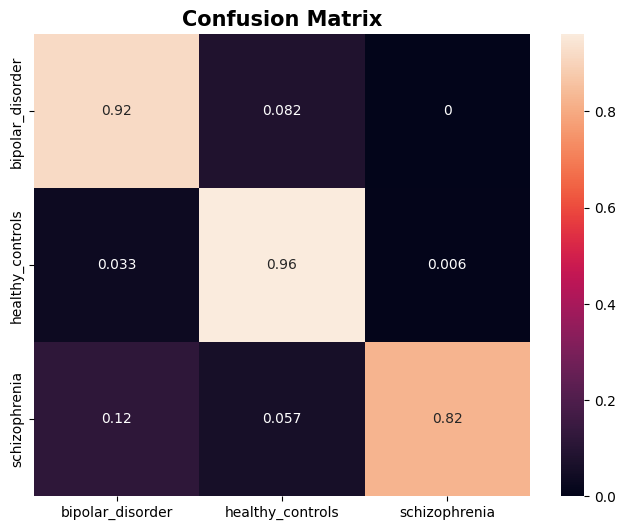

In [48]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN1_cm.png')
plt.show()

In [30]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.919309675693512
Precision: 0.9244499617859653
Sensitivity: 0.9183768656716418
Specificity: 0.9505136745220332
